In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

from joblib import load
from utils.visualize import showMe
from IPython.display import clear_output
import datetime
import brainflow
from scipy import signal

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowError

from tqdm.notebook import tqdm



from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


%matplotlib inline



from utils.visualize import showMe, stat
from utils.ros import connect, commands
from utils.record import preProcess, DCFilter
%load_ext autoreload
%autoreload 2

classes = ['Rest', 'Eyebrow','Smile', 'Chew']

C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [ ]:
ros, talker = connect()

In [2]:
####      INIT BOARD        #######
BoardShim.enable_dev_board_logger()
params = BrainFlowInputParams()
board = BoardShim(BoardIds.MINDROVE_WIFI_BOARD, params)


try:
    board.stop_stream()
    board.release_session()
except:
    ...
    
board.prepare_session()
sample_rate = board.get_sampling_rate(16)
print("Device ready (sampling rate: {}hz)".format(sample_rate))

Device ready (sampling rate: 500hz)


In [3]:
def predict(svm, sample):
    sample = preProcess(sample)
    prediction = svm.predict(sample.reshape(-1,6*100))[0]

    #######################################
    if int(prediction) == 1:
        talker.publish(commands['forward'])
    if int(prediction) == 2:
        talker.publish(commands['left'])
    if int(prediction) == 3:
        talker.publish(commands['right'])
    #######################################

    prediction_class = classes[int(prediction)]
    
    showMe(sample)
    print(f'Prediction: {prediction_class}')
    return prediction_class

def JustDoIt(std_threshold=200, cut = 2000):

    command_history = []
    print("Loading model...")

    svm = load('saved_models/svm_02_27.joblib')

  
    board.start_stream(450000)

    time.sleep(2)   #WAIT TO DC AVERAGE STAND IN
    print("Starting...")

    action_time = None
    block_time = None
    while True:
        time.sleep(0.001)
        data = board.get_current_board_data(sample_rate*60) #1min
        data = DCFilter(data)
        data = data[:6,-500:] #keep the data of the eeg channels only, and remove data over the trial length
        _, _, std = stat(data)
       
        
        if std == 0:
            print("[ERROR] No data collected! Check the MindRove device and try again.")
            break
        
        is_block = False
        if block_time is not None:
            is_block = datetime.datetime.now() < block_time
        if action_time is None and not is_block:
            if std > std_threshold:
                action_time  =  datetime.datetime.now()
                stop_time = action_time + datetime.timedelta(milliseconds=500)
        else:
            time_diff = (datetime.datetime.now() - stop_time).total_seconds()
            if abs(time_diff) < 0.01:
                clear_output()
                command_history.append(predict(svm, data))
                print(command_history)
                
                action_time = None
                block_time = datetime.datetime.now()+datetime.timedelta(milliseconds=1000)


['Chew', 'Rest', 'Chew', 'Chew', 'Chew', 'Rest', 'Chew', 'Rest', 'Blink', 'Smile', 'Chew', 'Rest', 'Rest', 'Rest', 'Blink', 'Smile', 'Smile', 'Smile', 'Blink', 'Chew', 'Chew', 'Rest', 'Blink', 'Smile', 'Smile', 'Smile', 'Smile', 'Smile', 'Smile', 'Smile', 'Smile', 'Smile', 'Smile']


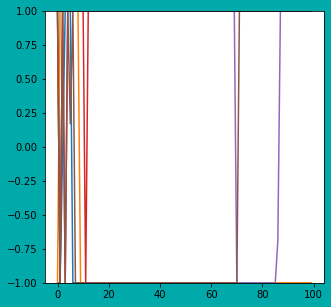

Prediction: Smile


KeyboardInterrupt: 

In [4]:
JustDoIt()

In [ ]:
def done():
    talker.unadvertise()
    ros.terminate()
    board.stop_stream()
    board.release_session()
done()